In [1]:
import os

default_n_threads = 8
os.environ['OPENBLAS_NUM_THREADS'] = f"{default_n_threads}"
os.environ['MKL_NUM_THREADS'] = f"{default_n_threads}"
os.environ['OMP_NUM_THREADS'] = f"{default_n_threads}"

import numpy as np
import pickle
import glob
import pandas as pd
from umap import UMAP
import hdbscan
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.cluster import KMeans


df_path = "/mnt/dobby-resources/arena_logs/dobby_arena_logs_en_cleaned.csv"
df = pd.read_csv(df_path)
df = df.drop_duplicates(subset=['question'], keep='first')
# Path to embeddings
embeddings_path = "/ephemeral/query_embeddings_en_sentence_transformer/"

/home/ubuntu/salah/data_collection/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load all embeddings
embeddings = []
file_indices = []

print("Loading embeddings...")
# Get valid entry_ids from dataframe
valid_entry_ids = df['entry_id'].dropna().astype(int).values

# Create list of expected filenames
expected_files = [os.path.join(embeddings_path, f"embedding_{idx}.pkl") for idx in valid_entry_ids]
# Filter to only existing files
existing_files = [f for f in expected_files if os.path.exists(f)]

# Sample if needed
sample_size = 50_000  # Adjust this number as needed
sampled_files = np.random.choice(existing_files, size=min(sample_size, len(existing_files)), replace=False)

for filepath in tqdm(sampled_files):    
    # Load embedding
    with open(filepath, 'rb') as f:
        embedding = pickle.load(f)
        embeddings.append(embedding.flatten())  # Flatten (1,embed_dim) to (embed_dim,)
        file_indices.append(os.path.basename(filepath))  # Store filename for reference

# Convert to numpy array
embeddings = np.array(embeddings)

Loading embeddings...


100%|██████████| 50000/50000 [00:00<00:00, 54440.41it/s]


In [3]:
# Reduce dimensions with UMAP
print("Reducing dimensions with UMAP...")
umap_reducer = UMAP(n_components=2,
                   n_neighbors=15,      # Increased for more stability
                   min_dist=0.1,
                   metric='cosine',
                   random_state=42,
                   init='random',       # Use random initialization instead of spectral
                   transform_queue_size=4,  # Helps with memory usage
                   a=1.0,               # Increase the importance of local structure
                   b=0.8)               # Slightly decrease the influence of outliers
embeddings_2d = umap_reducer.fit_transform(embeddings)

/home/ubuntu/salah/data_collection/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ubuntu/salah/data_collection/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Reducing dimensions with UMAP...


In [4]:
# MiniBatchKMeans processes data in smaller chunks
kmeans = KMeans(n_clusters=3, 
                          random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_2d)

# Create a DataFrame with results
results_df = pd.DataFrame({
    'file_index': file_indices,
    'cluster': cluster_labels,
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1]
})

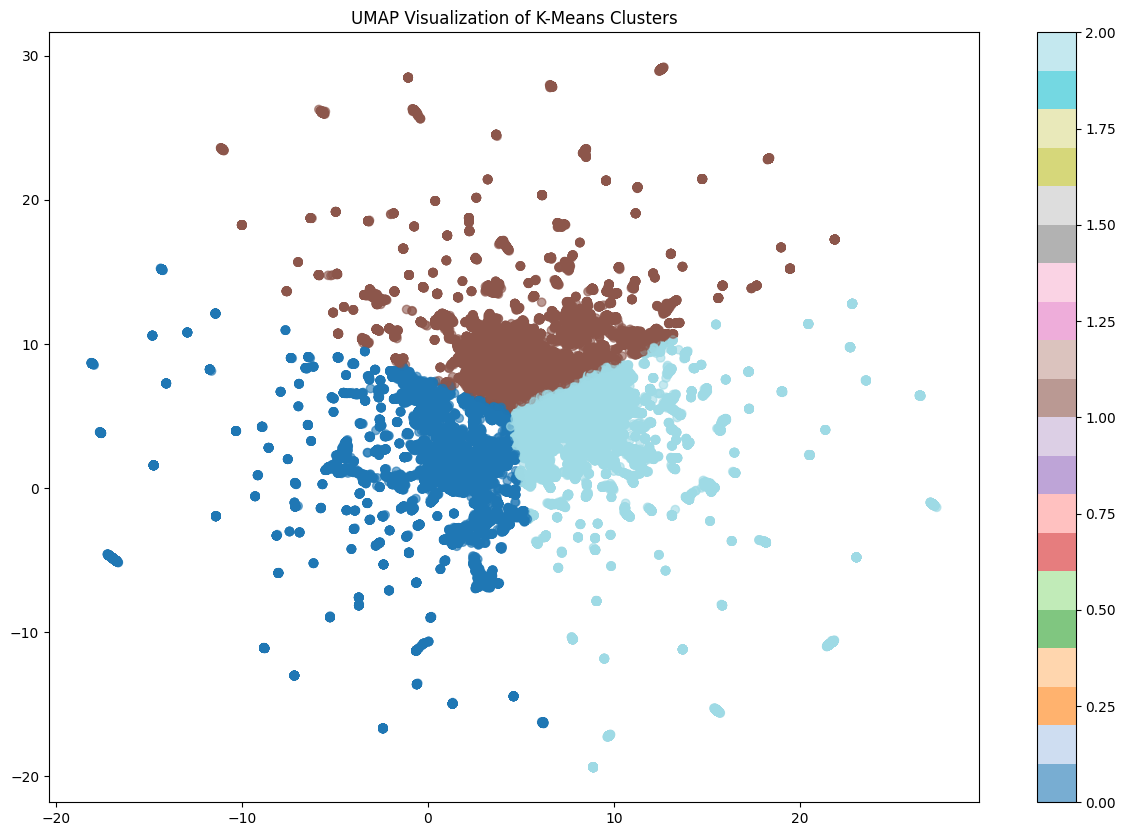


Cluster sizes:
cluster
0    16162
1    17317
2    16521
Name: count, dtype: int64


In [5]:
# Visualize clusters
plt.figure(figsize=(15, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=cluster_labels, cmap='tab20', alpha=0.6)
plt.colorbar(scatter)
plt.title('UMAP Visualization of K-Means Clusters')
plt.show()

# Print cluster statistics
print("\nCluster sizes:")
print(results_df['cluster'].value_counts().sort_index())

In [6]:
# Sample and display examples from each cluster
print("\nSampling examples from each cluster:")
for cluster_id in sorted(set(cluster_labels)):
    if cluster_id == -1:
        continue  # Skip noise points
        
    # Get indices for this cluster
    cluster_mask = results_df['cluster'] == cluster_id
    cluster_files = results_df[cluster_mask]['file_index'].values
    
    # Sample 3 random files from cluster
    sample_files = np.random.choice(cluster_files, size=min(100, len(cluster_files)), replace=False)
    
    print(f"\nCluster {cluster_id} samples:")
    # Load and print the original questions
    for file in sample_files:
        # Extract entry_id from filename (removing .pkl and 'embedding_' prefix)
        entry_id = int(file.replace('.pkl', '').replace('embedding_', ''))
        # Get the question using entry_id
        question = df[df['entry_id'] == entry_id]['question'].iloc[0] if not df[df['entry_id'] == entry_id].empty else "Question not found"
        print(f"- {question}")


Sampling examples from each cluster:

Cluster 0 samples:
- will Polymer have an airdrop?
- I have a youtube channel can you give some tips to grow my channel?
- What is the purpose of the appendix in the human body?
- meme coin or crypto
- The most important thing is to have a future goal for a project, not just a temporary goal
- Who and what category
- I have an accident and my hand get hurt, i can not access internet. You play the role as me.
- What's Hyperliquid?
- DC or marvel?
- tell me BTC prediction for next 30 days
- What is the tallest building in the world?
- What is the role of blockchain technology in the development of the Internet of Things (IoT)?
- i am fine and you?
- do you know their x acc ?
- tell me about yourself
- narrative in crypto
- Who is the fastest footballer of all time?
- If you could instantly master one skill that would make you stand out in a crowd, what would it be and how would you use it?

- sentient ne zaman listelenecek
- how to update python
- w

In [8]:
# Save questions from each cluster to separate files
print("\nSaving questions from each cluster to files...")
for cluster_id in sorted(set(cluster_labels)):
    if cluster_id == -1:
        continue  # Skip noise points
        
    # Get all files for this cluster
    cluster_mask = results_df['cluster'] == cluster_id
    cluster_files = results_df[cluster_mask]['file_index'].values
    
    # Create a file for this cluster
    with open(f'cluster_{cluster_id}.txt', 'w', encoding='utf-8') as f:
        # Write header with cluster info
        f.write(f"Questions from Cluster {cluster_id}\n")
        f.write("=" * 50 + "\n\n")
        
        # Get and write all questions from this cluster
        for file in cluster_files:
            entry_id = int(file.replace('.pkl', '').replace('embedding_', ''))
            question = df[df['entry_id'] == entry_id]['question'].iloc[0] if not df[df['entry_id'] == entry_id].empty else "Question not found"
            f.write(f"{question}\n")
            
    print(f"Saved {len(cluster_files)} questions to cluster_{cluster_id}.txt")


Saving questions from each cluster to files...
Saved 16162 questions to cluster_0.txt
Saved 17317 questions to cluster_1.txt
Saved 16521 questions to cluster_2.txt
